# Data Training using Sklearn

In [1]:
%matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
X_train = pd.read_csv('./data/train_processed.csv')
X_predict = pd.read_csv('./data/test_processed.csv')
predict_id = pd.read_csv('./data/test.csv')['PassengerId']

In [3]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,UnknownAge,Baby,Child,Young,...,Ticket_SOTONOQ.1,Ticket_SP.1,Ticket_STONO.1,Ticket_STONO2.1,Ticket_STONOQ.1,Ticket_SWPP.1,Ticket_WC.1,Ticket_WEP.1,Ticket_XXX.1,Survived
0,3,1,0.273456,1,0,0.014151,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0.473882,1,0,0.139136,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0.323563,0,0,0.015469,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,1,0,0.436302,1,0,0.103644,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,3,1,0.436302,0,0,0.015713,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Split into 3 sets: train, test and valid

In [4]:
y_train = X_train['Survived']
X_train = X_train.drop('Survived', axis=1)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train.drop('Survived', axis=1), y_train, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [5]:
print('Training set', X_train.shape, y_train.shape)
#print('Validation set', X_valid.shape, y_valid.shape)
#print('Test set', X_test.shape, y_test.shape)

Training set (891, 105) (891,)


In [ ]:
def reformat(X, y):
    #X = X.reshape((-1, -1)).astype(np.float32)
    y = (np.arange(1) == y[:,None]).astype(np.float32)
    return X, y

In [ ]:
X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)

In [ ]:
print('Training set', X_train.shape, y_train.shape)
#print('Validation set', X_valid.shape, y_valid.shape)
#print('Test set', X_test.shape, y_test.shape)

In [6]:
kfold = StratifiedKFold(n_splits=10)

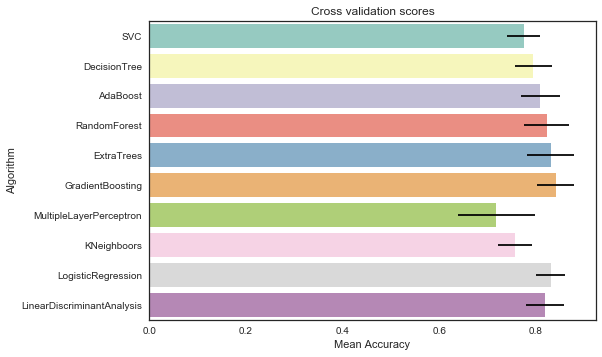

In [7]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [8]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train, y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 352 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    4.9s finished


In [9]:
gsadaDTC.best_score_

0.81593714927048255

In [10]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   57.9s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.2min finished


0.83950617283950613

In [11]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.2min finished


0.83838383838383834

In [12]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   37.5s finished


0.83389450056116721

In [13]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train, y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   47.4s finished


0.83613916947250277

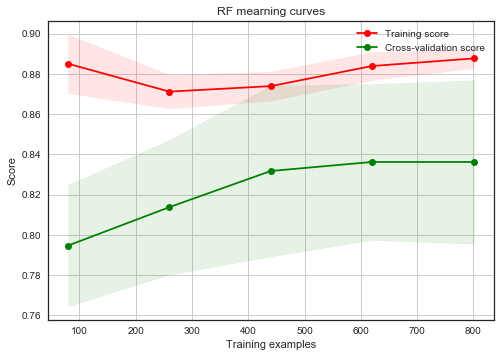

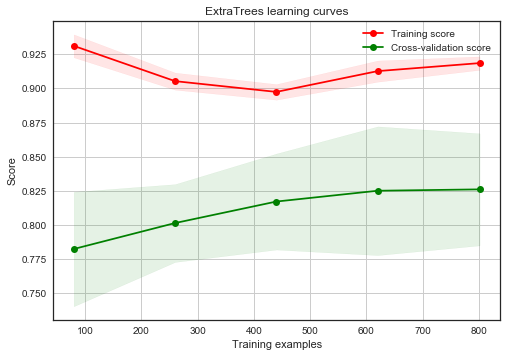

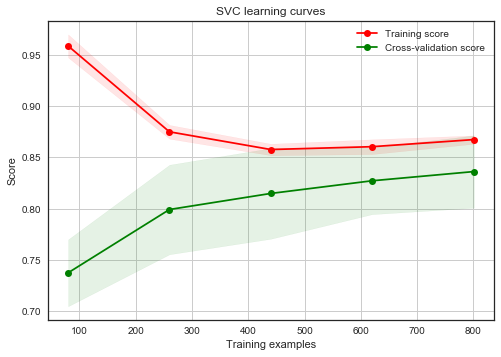

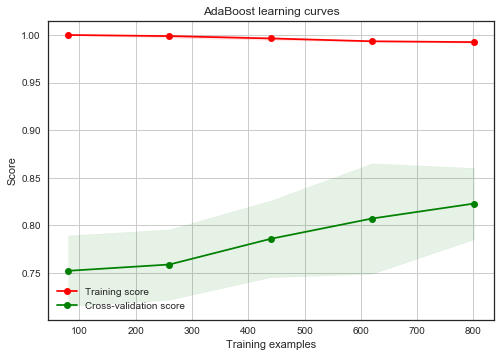

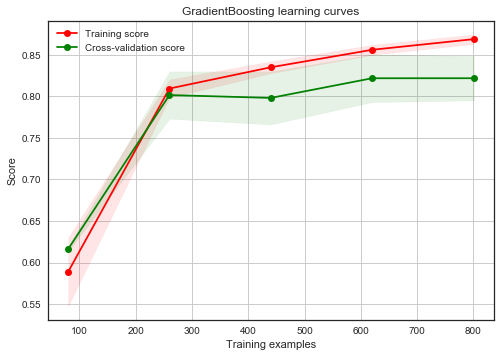

In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, y_train, cv=kfold)

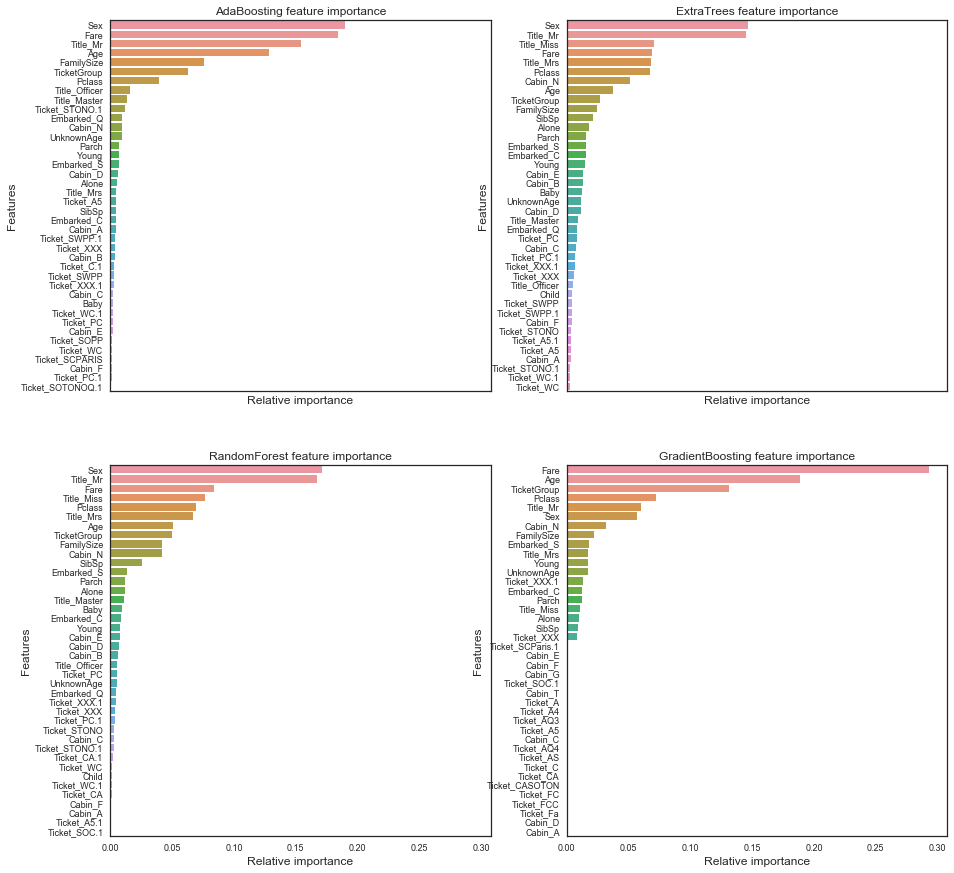

In [15]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

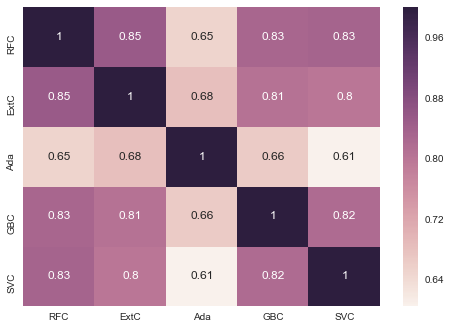

In [16]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_predict), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_predict), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_predict), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_predict), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_predict), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, \
                              test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)


g = sns.heatmap(ensemble_results.corr(),annot=True)

In [17]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc', GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [18]:
predict_survived = pd.Series(votingC.predict(X_predict), name="Survived")
results = pd.concat([predict_id, predict_survived], axis=1)

results.to_csv("./data/output.csv", index=False)

## Reduced features test

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [20]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

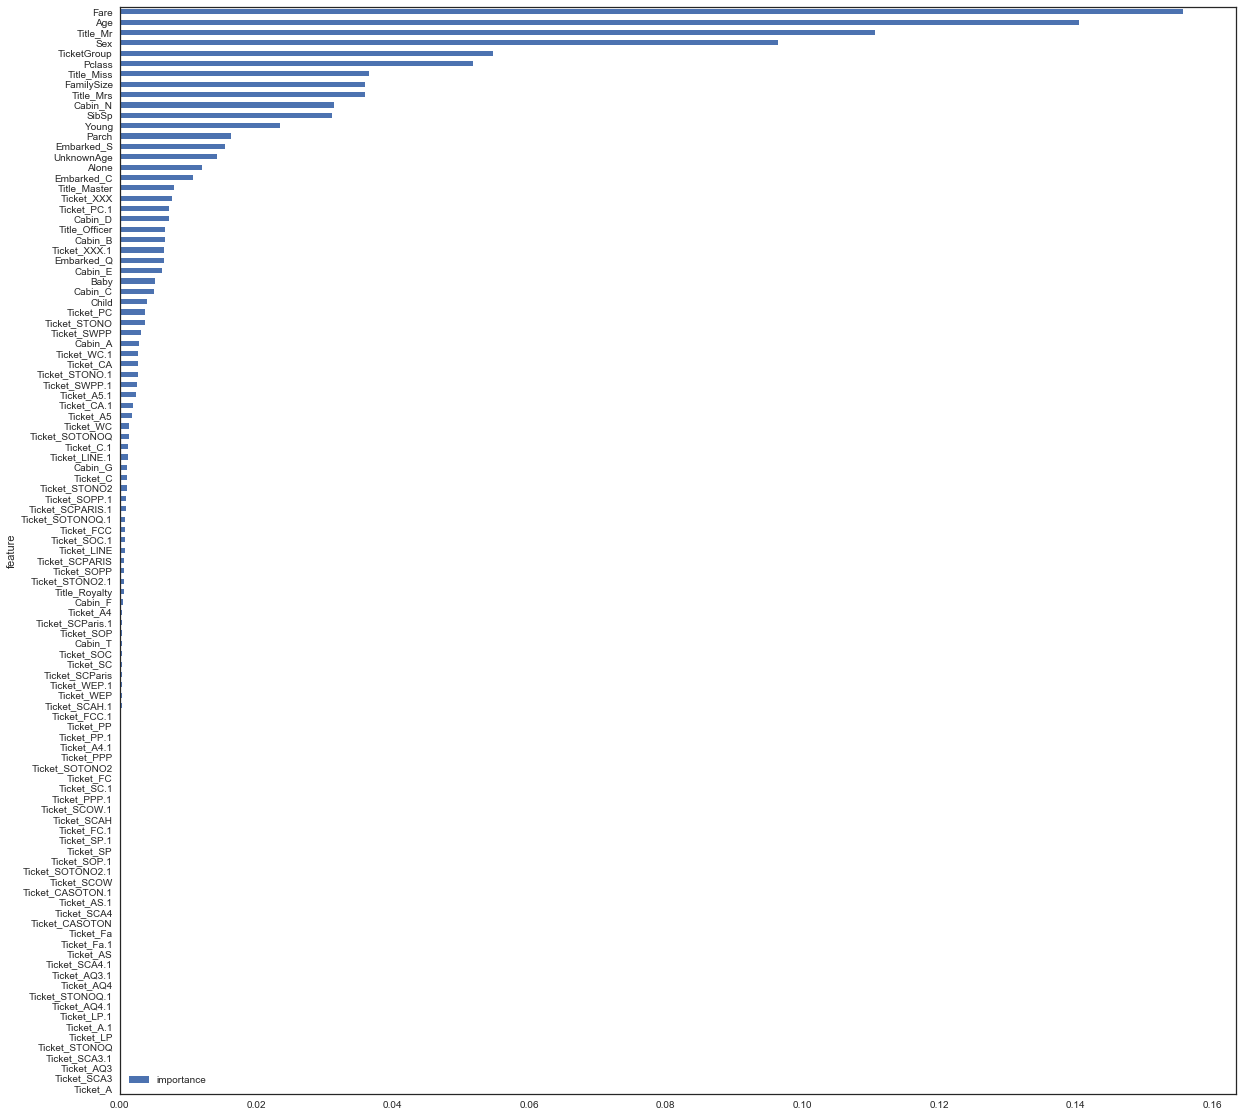

In [21]:
features.plot(kind='barh', figsize=(20, 20))

In [22]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(X_train)
train_reduced.shape

(891, 17)

In [23]:
test_reduced = model.transform(X_predict)
test_reduced.shape

(418, 17)

In [24]:
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [1, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(targets, n_folds=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(X_train, y_train)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(X_train, y_train)

In [26]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [27]:
compute_score(model, X_train, y_train, scoring='accuracy')

0.82161024928478632

In [29]:
output = model.predict(X_predict).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('./data/output.csv',index=False)